In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns

from functions import *

## 1. Data Exploration & Cleaning

### 1.1 Demographics Table

In [2]:
# Load data
df_demo = pd.read_csv('../data/raw/df_final_demo.txt')

# Rename columns and explore table
df_demo = rename_demo_columns(df_demo)
data_exploration(df_demo)

Number of rows: 70609
Number of columns: 9
Number of duplicates: 0

Numerical Columns: Index(['client_id', 'tenure_year', 'tenure_month', 'age', 'number_of_accounts',
       'balance', 'calls_6_month', 'logons_6_month'],
      dtype='object')

Categorical Columns: Index(['gender'], dtype='object')


,Column,Data Type,Non-Null Count,Missing Values,Unique Values
0,client_id,int64,70609,0,70609
1,tenure_year,float64,70595,14,54
2,tenure_month,float64,70595,14,482
3,age,float64,70594,15,165
4,gender,object,70595,14,4
5,number_of_accounts,float64,70595,14,8
6,balance,float64,70595,14,70328
7,calls_6_month,float64,70595,14,8
8,logons_6_month,float64,70595,14,9


<ins>Observations:</ins>
- For some client_ids we find a few missing values (14 to 15). Taking into account the large number of total rows (> 70k), we can fill the mising values with mean and mode for numerical and categorical columns, respectively, without changing the distribution.
- In the columns we identify seven numerical variables ('tenure_year', 'tenure_month', 'age', 'number_of_accounts', 'balance', 'calls_6_month', 'logons_6_month'), all with data type float. Some numerical variables should be integer instead ('number_of_accounts', 'calls_6_month', 'logons_6_month'). In addition, we find two categorical variables ('gender', 'client_id'), of which one ('client_id') is of type integer, but should better be string (object-type).

In [3]:
# Select categorical and numerical columns
cols_demo_numerical = ['tenure_year', 'tenure_month', 'age', 'number_of_accounts', 'balance', 'calls_6_month', 'logons_6_month']
cols_demo_categorical = ['gender', 'client_id']

# Fill missing values in numerical columns with the mean and in categorical columns with the mode
df_demo = fill_missing(df_demo, cols_demo_numerical, cols_demo_categorical)

# Change discrete numerical variables from type float to integer + client_id from integer to object
df_demo[['number_of_accounts', 'calls_6_month', 'logons_6_month']] = df_demo[['number_of_accounts', 'calls_6_month', 'logons_6_month']].astype(("int64"))
df_demo['client_id'] = df_demo['client_id'].astype("object")

# Save cleaned dataframe to csv-file
df_demo.to_csv("../data/cleaned/df_final_demo_cleaned.csv", index=False)

### 1.2 Web Data Table

In [4]:
# Load data
df_web_data_pt_1 = pd.read_csv('../data/raw/df_final_web_data_pt_1.txt')
df_web_data_pt_2 = pd.read_csv('../data/raw/df_final_web_data_pt_2.txt')

# Concatenate two parts
df_web_data = pd.concat([df_web_data_pt_1, df_web_data_pt_2], axis=0)

# Explore table
data_exploration(df_web_data)

Number of rows: 755405
Number of columns: 5
Number of duplicates: 10764

Numerical Columns: Index(['client_id'], dtype='object')

Categorical Columns: Index(['visitor_id', 'visit_id', 'process_step', 'date_time'], dtype='object')


,Column,Data Type,Non-Null Count,Missing Values,Unique Values
0,client_id,int64,755405,0,120157
1,visitor_id,object,755405,0,130236
2,visit_id,object,755405,0,158095
3,process_step,object,755405,0,5
4,date_time,object,755405,0,629363


<ins>Observations:</ins>
- We find about 11k duplicates on a total of about 750k rows. We expect the duplicates to originate from technical errors in the data collection (e.g. a client clicks on a button and this action is recorded two times).
- As in the demographics table, also here the client_id is of type integer, but should be object.
- The date_time column is of type object. We convert it to datetime and split the column in two: date and time.

In [5]:
# Select categorical and numerical columns
cols_web_numerical = []
cols_web_categorical = ['client_id', 'visitor_id', 'visit_id', 'process_step', 'data_time']

In [6]:
# Change client_id column from type integer to object
df_web_data['client_id'] = df_web_data['client_id'].astype("object")

# Change date_time column from type object to datetime and split into date and time
df_web_data['date_time'] = pd.to_datetime(df_web_data['date_time'])
df_web_data['date'] = df_web_data['date_time'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
df_web_data['time'] = df_web_data['date_time'].apply(lambda x: pd.to_datetime(x, format='%H:%M:%S.%f'))
df_web_data = df_web_data.drop(columns='date_time')

# Drop duplicates
df_web_data = df_web_data.drop_duplicates()

# Save cleaned dataframe to csv-file
df_web_data.to_csv("../data/cleaned/df_final_web_data_cleaned.csv", index=False)

### 1.3 Experiment Clients Table

In [7]:
# Load data
df_clients = pd.read_csv('../data/raw/df_final_experiment_clients.txt')

# Rename column and explore table
df_clients = df_clients.rename(columns={'Variation': 'variation'})
data_exploration(df_clients)

Number of rows: 70609
Number of columns: 2
Number of duplicates: 0

Numerical Columns: Index(['client_id'], dtype='object')

Categorical Columns: Index(['variation'], dtype='object')


,Column,Data Type,Non-Null Count,Missing Values,Unique Values
0,client_id,int64,70609,0,70609
1,variation,object,50500,20109,2


<ins>Observations:</ins>
- We find about 20k missing values in a total of about 120k total values. As the information about a client being in the test or the control group is critical for the analysis, we decide to drop the rows with missing values.
- Again, the client_id column should be of type object instead of integer.

In [8]:
# Select categorical and numerical columns
cols_clients_numerical = []
cols_clients_categorical = ['client_id', 'variation']

In [9]:
# Change client_id column from type integer to object
df_clients['client_id'] = df_clients['client_id'].astype("object")

# Drop all missing values
df_clients = df_clients.dropna(subset=["variation"])

# Save cleaned dataframe to csv-file
df_clients.to_csv("../data/cleaned/df_final_experiment_clients_cleaned.csv", index=False)

## 2. Preliminary EDA

In [10]:
# Load clean tables
df_demo = pd.read_csv('../data/cleaned/df_final_demo_cleaned.csv')
df_clients = pd.read_csv('../data/cleaned/df_final_experiment_clients_cleaned.csv')
df_web_data = pd.read_csv('../data/cleaned/df_final_web_data_cleaned.csv')

### 2.1 Univariate Analysis

#### 2.1.1 Demographics Table

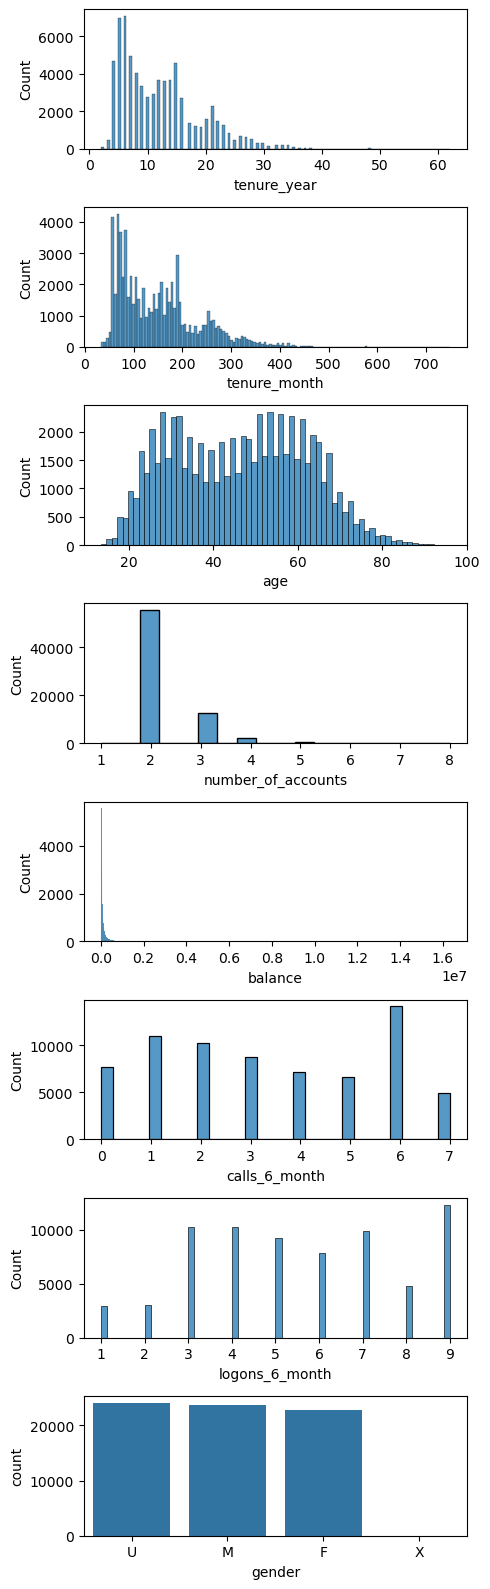

In [11]:
# Investigate distributions
plot_distributions_numerical(df_demo, cols_demo_numerical + ['gender'])

<ins>Observations</ins>
- Tenure year (and month): the distribution suggests that there are years in which subsequently more people become clients and then there are years in which the acquisition of clients declines again.
- Age: the distribution shows two distinct peaks, which could be related to the trends in client acqusition seen above. In general there is a wide range of age and no trend is to be observed.
- Number of accounts: most people have two accounts, some have three and only very few have four or more.
- Balance: ...
- Calls: ...
- Logons: ...
- Gender: ...

#### 2.1.2 Web Data Table

In [12]:
df_web_data.dtypes.astype(str)['process_step']

'object'

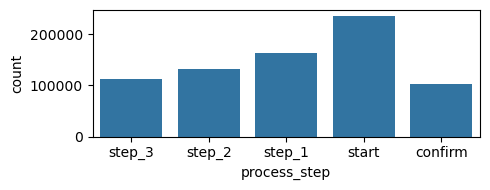

In [13]:
# Investigate distributions
plot_distributions_numerical(df_web_data, ['process_step'])

#### 2.1.3 Experiment Clients Table

### 2.2 Bivariate Analysis

#### 2.2.1 Demographics Table

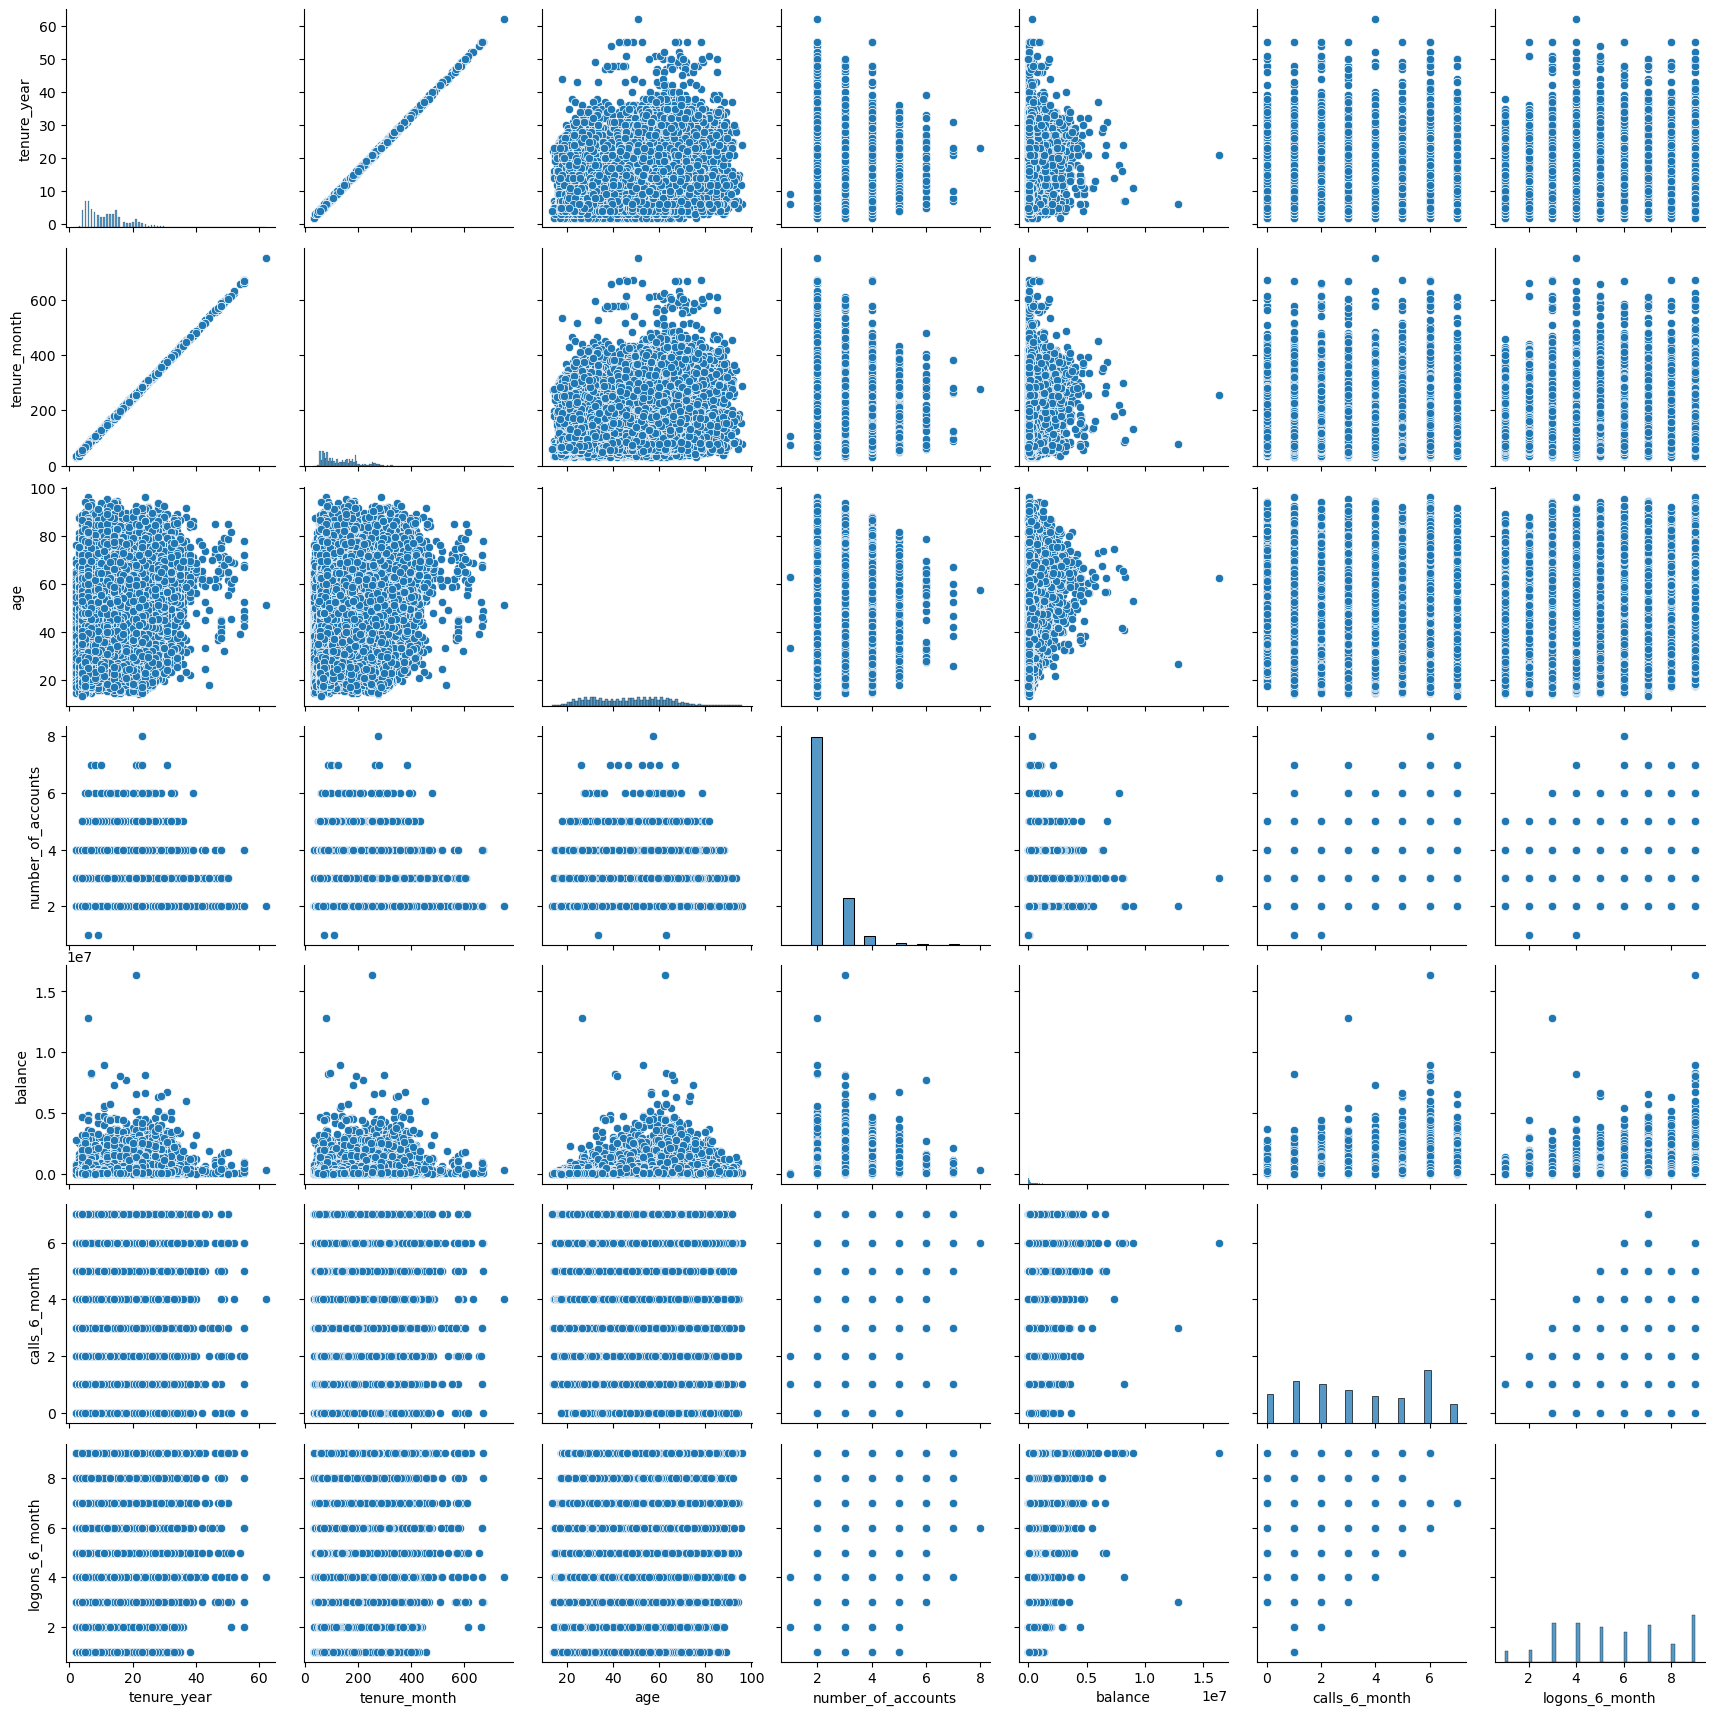

In [14]:
g = sns.PairGrid(df_demo[cols_demo_numerical])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

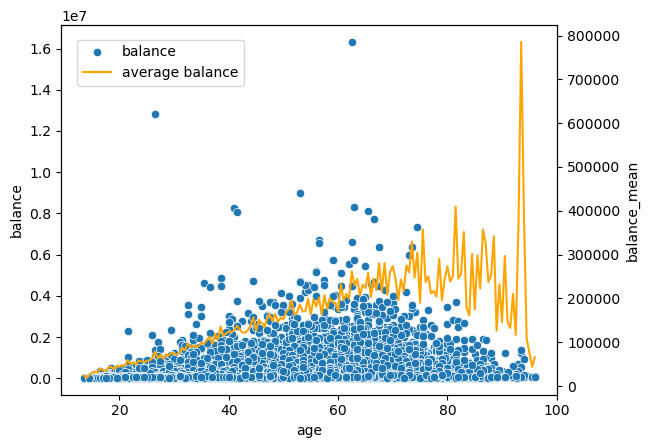

In [50]:
# Investigate association of age and balance
df_age_bal = pd.DataFrame({'age': pd.pivot_table(df_demo, index="age", values="balance", aggfunc='mean').index,
                           'balance_mean': pd.pivot_table(df_demo, index="age", values="balance", aggfunc='mean').balance})

fig, ax = plt.subplots()
sns.scatterplot(df_demo, x="age", y="balance", ax=ax)
ax2 = ax.twinx()
sns.lineplot(df_age_bal, x="age", y="balance_mean", ax=ax2, color='orange')
fig.legend(labels=['balance','average balance'], bbox_to_anchor=(0.15, 0.85), loc='upper left', borderaxespad=0)
plt.show()